# EDA
Includes code from Purvi, Eric, André, Michael. Merge done by Michael, reviewed by group.

@all:  
I use a max code line length of 79, as suggested by PEP-8, as this is useful when you want to compare code side by side (https://github.com/python/peps/blob/main/peps/pep-0008.rst). You can setup VS Code to show a ruler/marker (or several of them) to help keep line length in check: https://levelup.gitconnected.com/do-you-know-about-rulers-in-visual-studio-code-f754b221a135. Nice to have, not a must. I'm open for any discussions about this.

## Setup

In [5]:
# import the usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

# nltk (Natural Language Toolkit, https://www.nltk.org)
import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist

# download stuff for nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# other imports
from wordcloud import WordCloud # https://pypi.org/project/wordcloud/
from collections import Counter
import string
import re
import missingno as msno

# @André and all:
# I leave warnings switched on. They can be annoying, yes, but I think
# they are usually thrown for a good reason and it's probably always
# better to write code that doesn't produce them in order to avoid
# problems further down the road.
#import warnings
#warnings.filterwarnings("ignore")

# increase number of displayed df columns, since data has quite many
# (default is 20)
pd.options.display.max_columns = 100

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ericmartinez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ericmartinez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ericmartinez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [6]:
# merged_data.csv contains only complete rows (~ 450,000 of a total 2M)
# Target: 'toxic' column (1 if 'toxicity' >= 0.5)
df = pd.read_csv('data/merged_data.csv')

## Define column groups

In [7]:

main_cols = ['id', 'comment_text', 'split', 'toxicity']

subtype_cols = ['severe_toxicity', 'obscene', 'insult', 'threat',
                'identity_attack','sexual_explicit']

metadata_cols = ['created_date', 'publication_id', 'parent_id',
                 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes',
                 'disagree', 'identity_annotator_count',
                 'toxicity_annotator_count']

identity_cols = ['male', 'female', 'transgender', 'other_gender',
                 'heterosexual', 'homosexual_gay_or_lesbian',
                 'bisexual', 'other_sexual_orientation', 'christian',
                 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist',
                 'other_religion', 'black', 'white', 'asian', 'latino',
                 'other_race_or_ethnicity', 'physical_disability',
                 'intellectual_or_learning_disability',
                 'psychiatric_or_mental_illness', 'other_disability']

# further split up identity columns
gender_cols = ['male', 'female', 'bisexual', 'transgender', 'heterosexual',
               'other_gender', 'homosexual_gay_or_lesbian',
               'other_sexual_orientation']

race_cols = ['asian', 'black', 'white', 'latino', 'other_race_or_ethnicity']

religion_cols = ['hindu', 'buddhist', 'christian', 'muslim', 'jewish',
                 'atheist', 'other_religion']

## First overview

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447998 entries, 0 to 447997
Data columns (total 44 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   id                                   447998 non-null  int64  
 1   comment_text                         447998 non-null  object 
 2   split                                447998 non-null  object 
 3   created_date                         447998 non-null  object 
 4   rating                               447998 non-null  object 
 5   funny                                447998 non-null  int64  
 6   wow                                  447998 non-null  int64  
 7   sad                                  447998 non-null  int64  
 8   likes                                447998 non-null  int64  
 9   disagree                             447998 non-null  int64  
 10  toxicity                             447998 non-null  float64
 11  severe_toxici

In [9]:
df.head()

,id,comment_text,split,created_date,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count,toxic
0,627762,OH yes - Were those evil Christian Missionarie...,train,2016-11-26 15:56:03.862109+00,approved,0,0,0,0,0,0.800000,0.000000,0.000000,0.000000,0.700000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,10,1
1,5892815,Why is this black racist crap still on the G&M...,train,2017-09-03 23:20:08.226613+00,rejected,0,0,0,0,0,0.757143,0.142857,0.471429,0.014286,0.614286,0.642857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,70,1
2,416437,even up here.......BLACKS!,train,2016-08-04 16:48:07.175252+00,rejected,0,0,0,1,0,0.688525,0.032787,0.049180,0.000000,0.639344,0.213115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,61,1
3,5137126,Blame men. There's always an excuse to blame ...,train,2017-04-15 19:00:45.032674+00,rejected,0,0,0,0,0,0.545455,0.000000,0.000000,0.000000,0.636364,0.272727,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,11,1
4,855753,And the woman exposing herself saying grab thi...,train,2017-01-18 01:50:57.478867+00,rejected,0,0,0,0,0,0.728571,0.000000,0.600000,0.628571,0.114286,0.300000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,70,1


In [10]:
# check for NaNs
print('Total # of NaNs in dataset:', df.isnull().sum().sum())

Total # of NaNs in dataset: 0


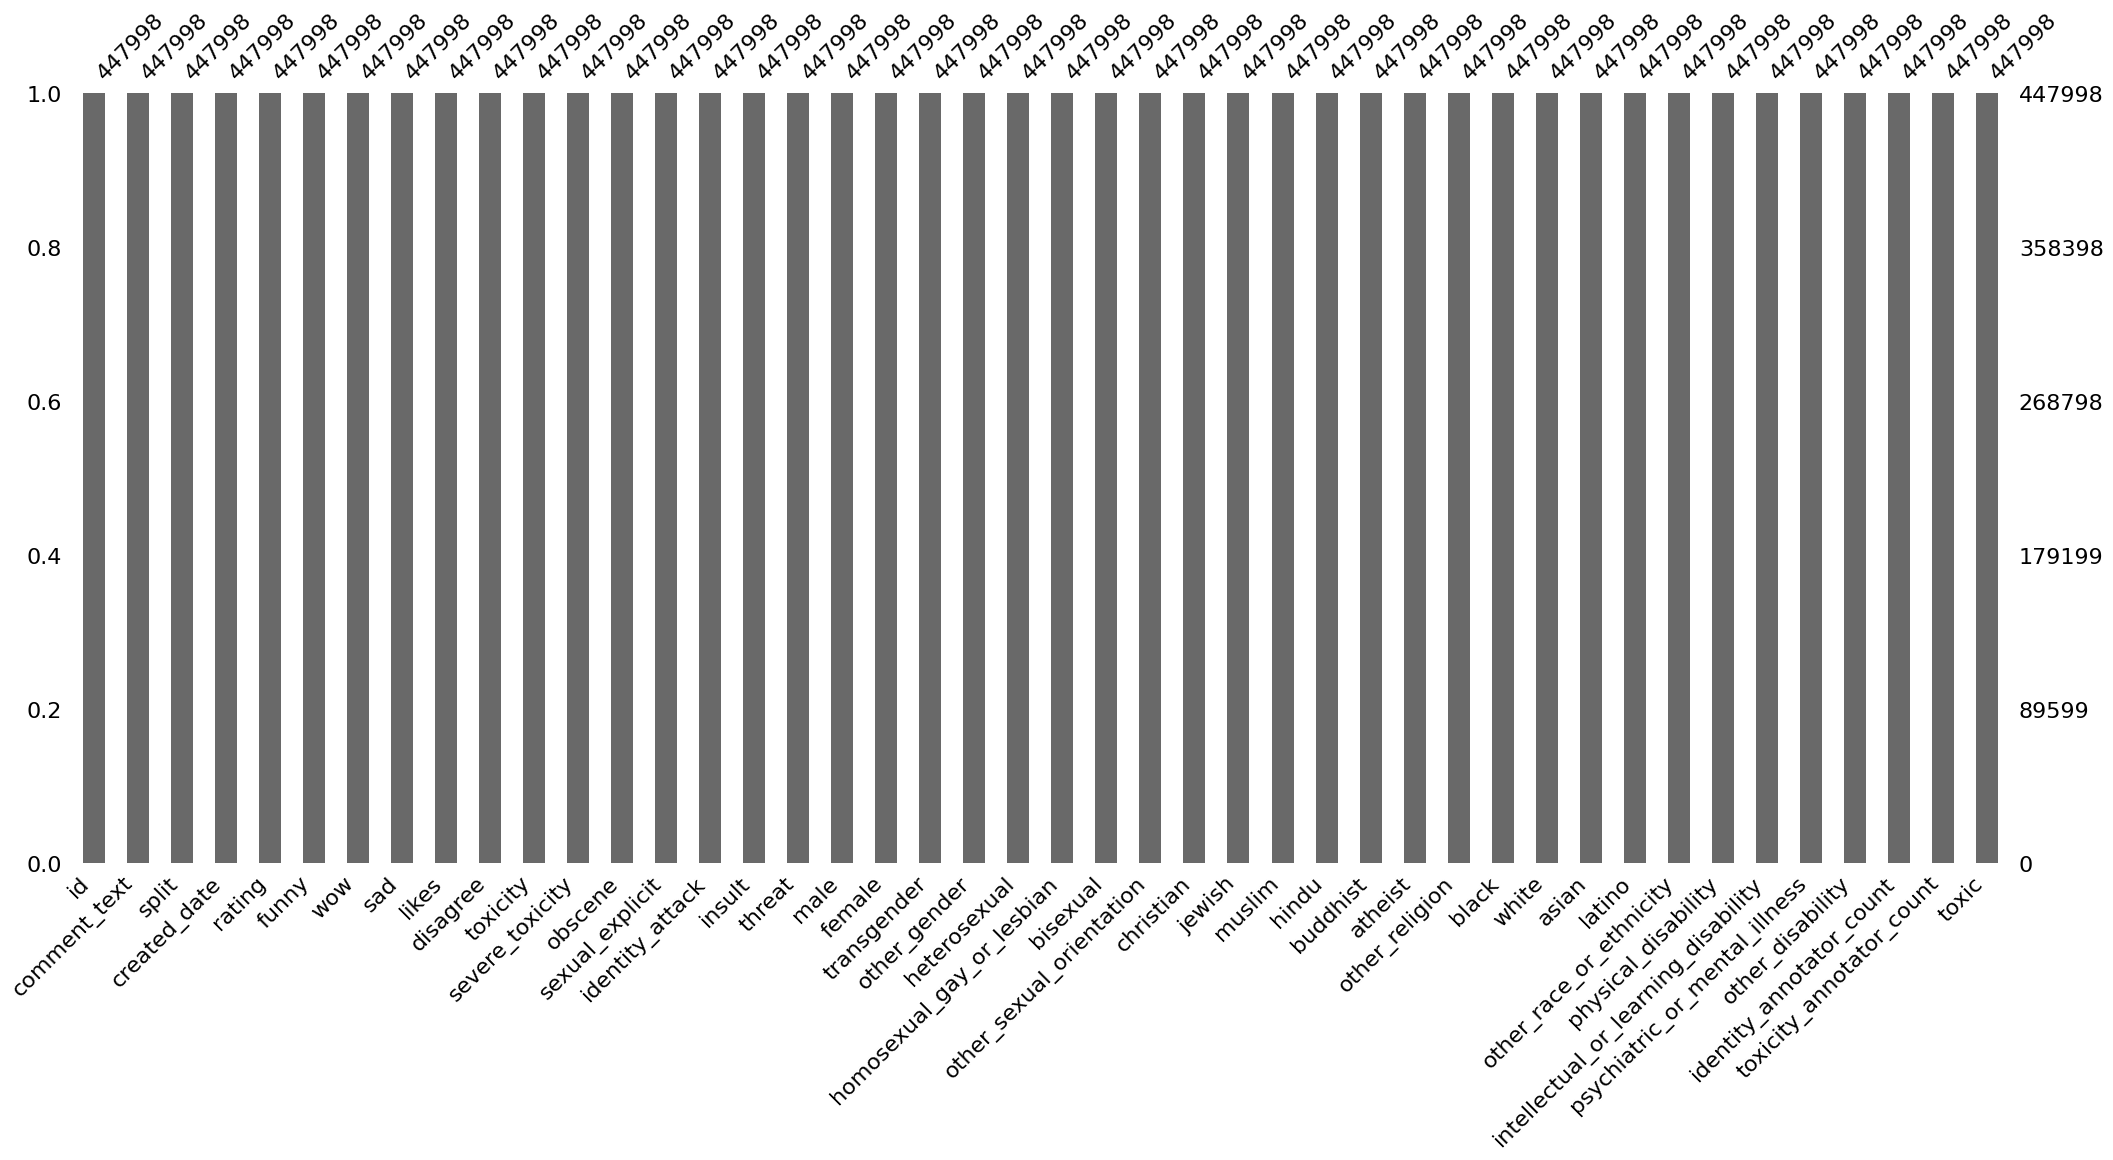

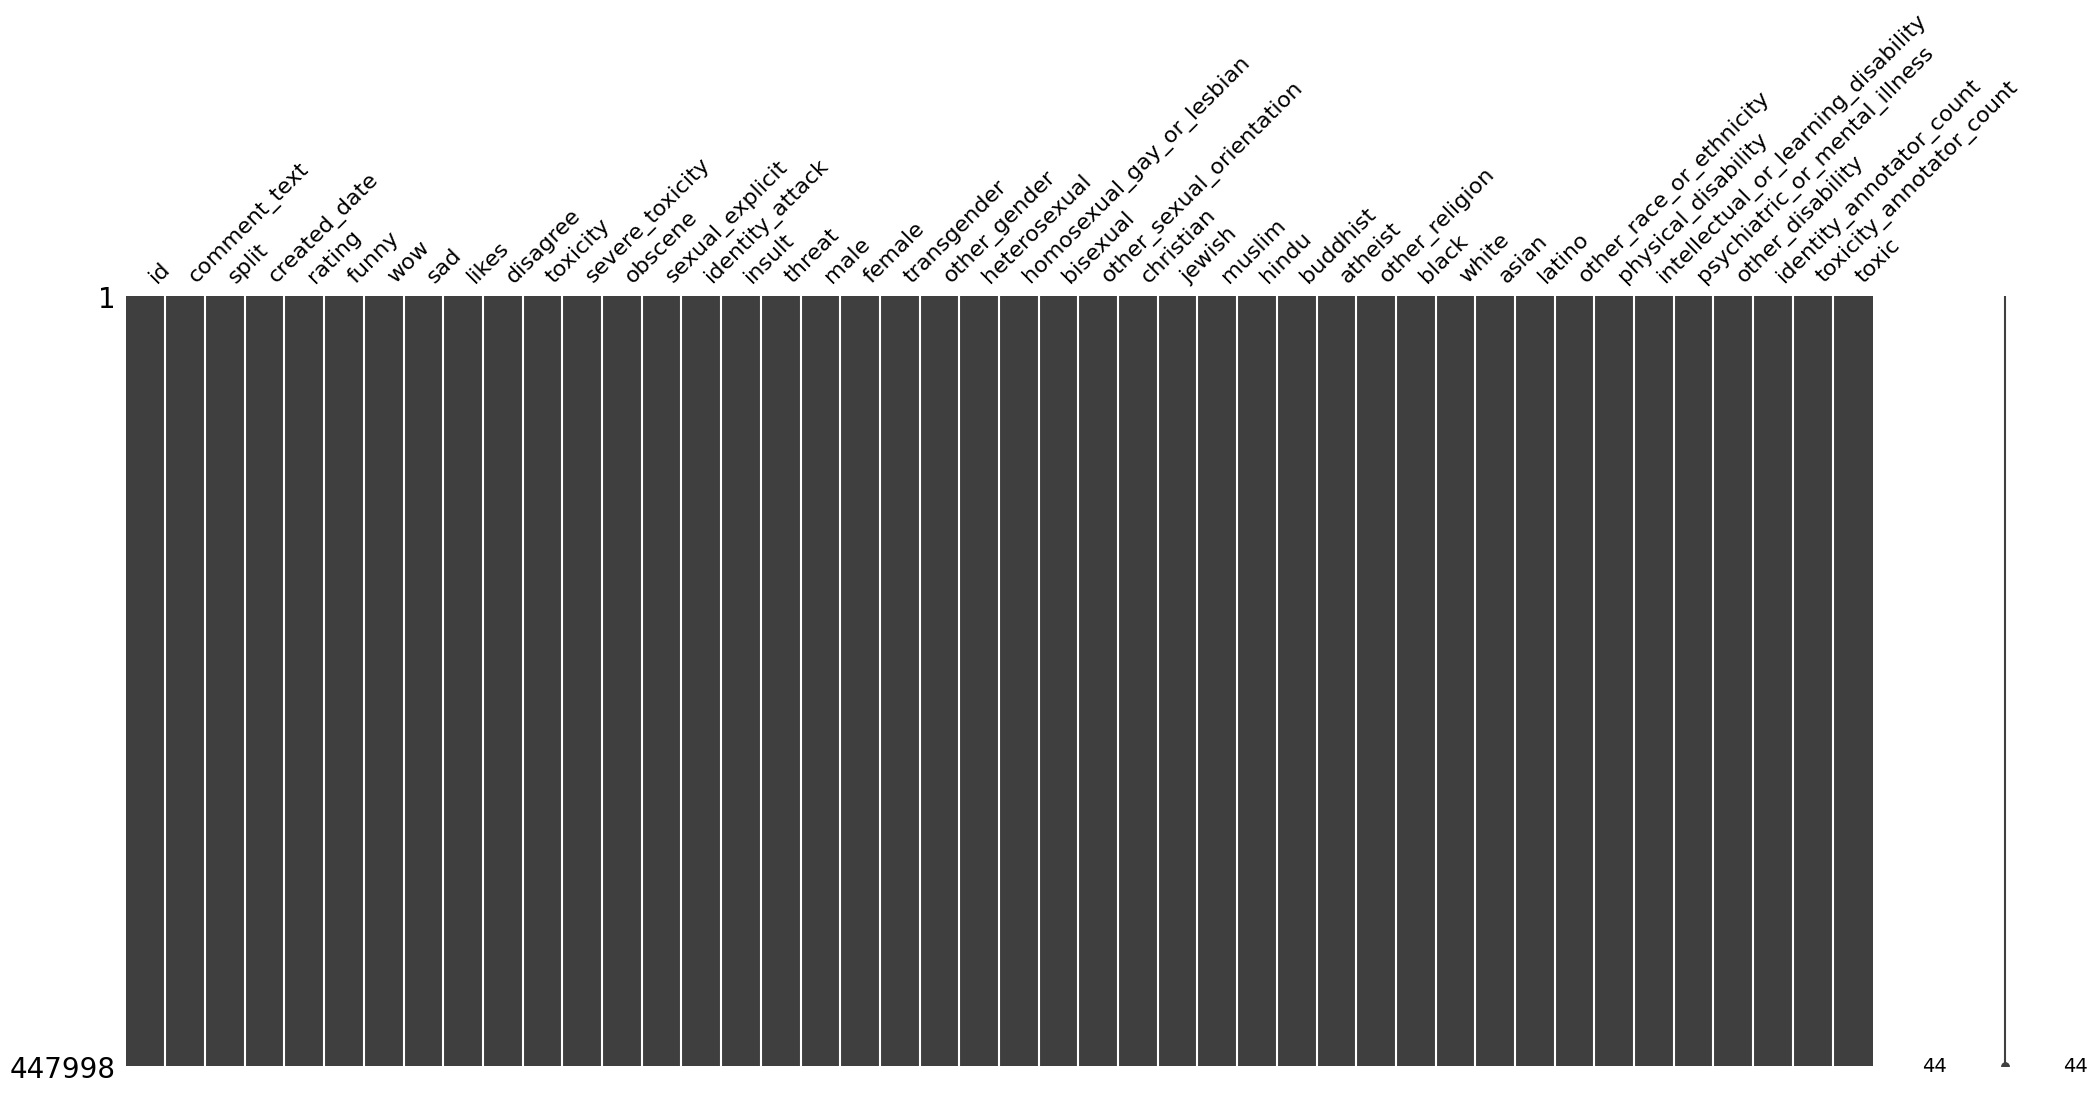

In [11]:
# check distribution of NaNs using Missingno
msno.bar(df)
msno.matrix(df);

In [12]:
# Check string columns other then comment_text. What's in there?
print('Column "rating":', df['rating'].unique())
print('Column "split":', df['split'].unique())

Column "rating": ['approved' 'rejected']
Column "split": ['train' 'test']


## Visualisations (Michael)

### Toxic vs non-toxic comments (pie plot)

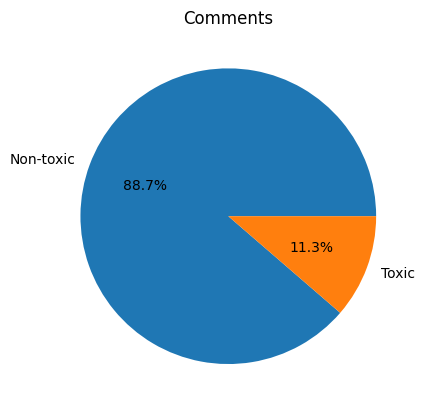

In [13]:
toxic_count = df['toxic'].value_counts()
toxic_count.plot.pie(labels=['Non-toxic', 'Toxic'], autopct='%.1f%%')
plt.title('Comments')
plt.ylabel(None);

--> __Dataset is strongly imbalanced!__

### Distribution of toxicity (histogram)

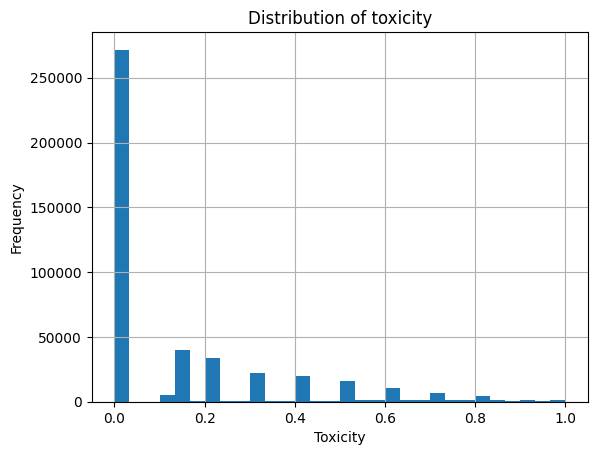

In [14]:
df['toxicity'].hist(bins=30)
plt.title('Distribution of toxicity')
plt.xlabel('Toxicity')
plt.ylabel('Frequency');

### Histograms for all numerical columns

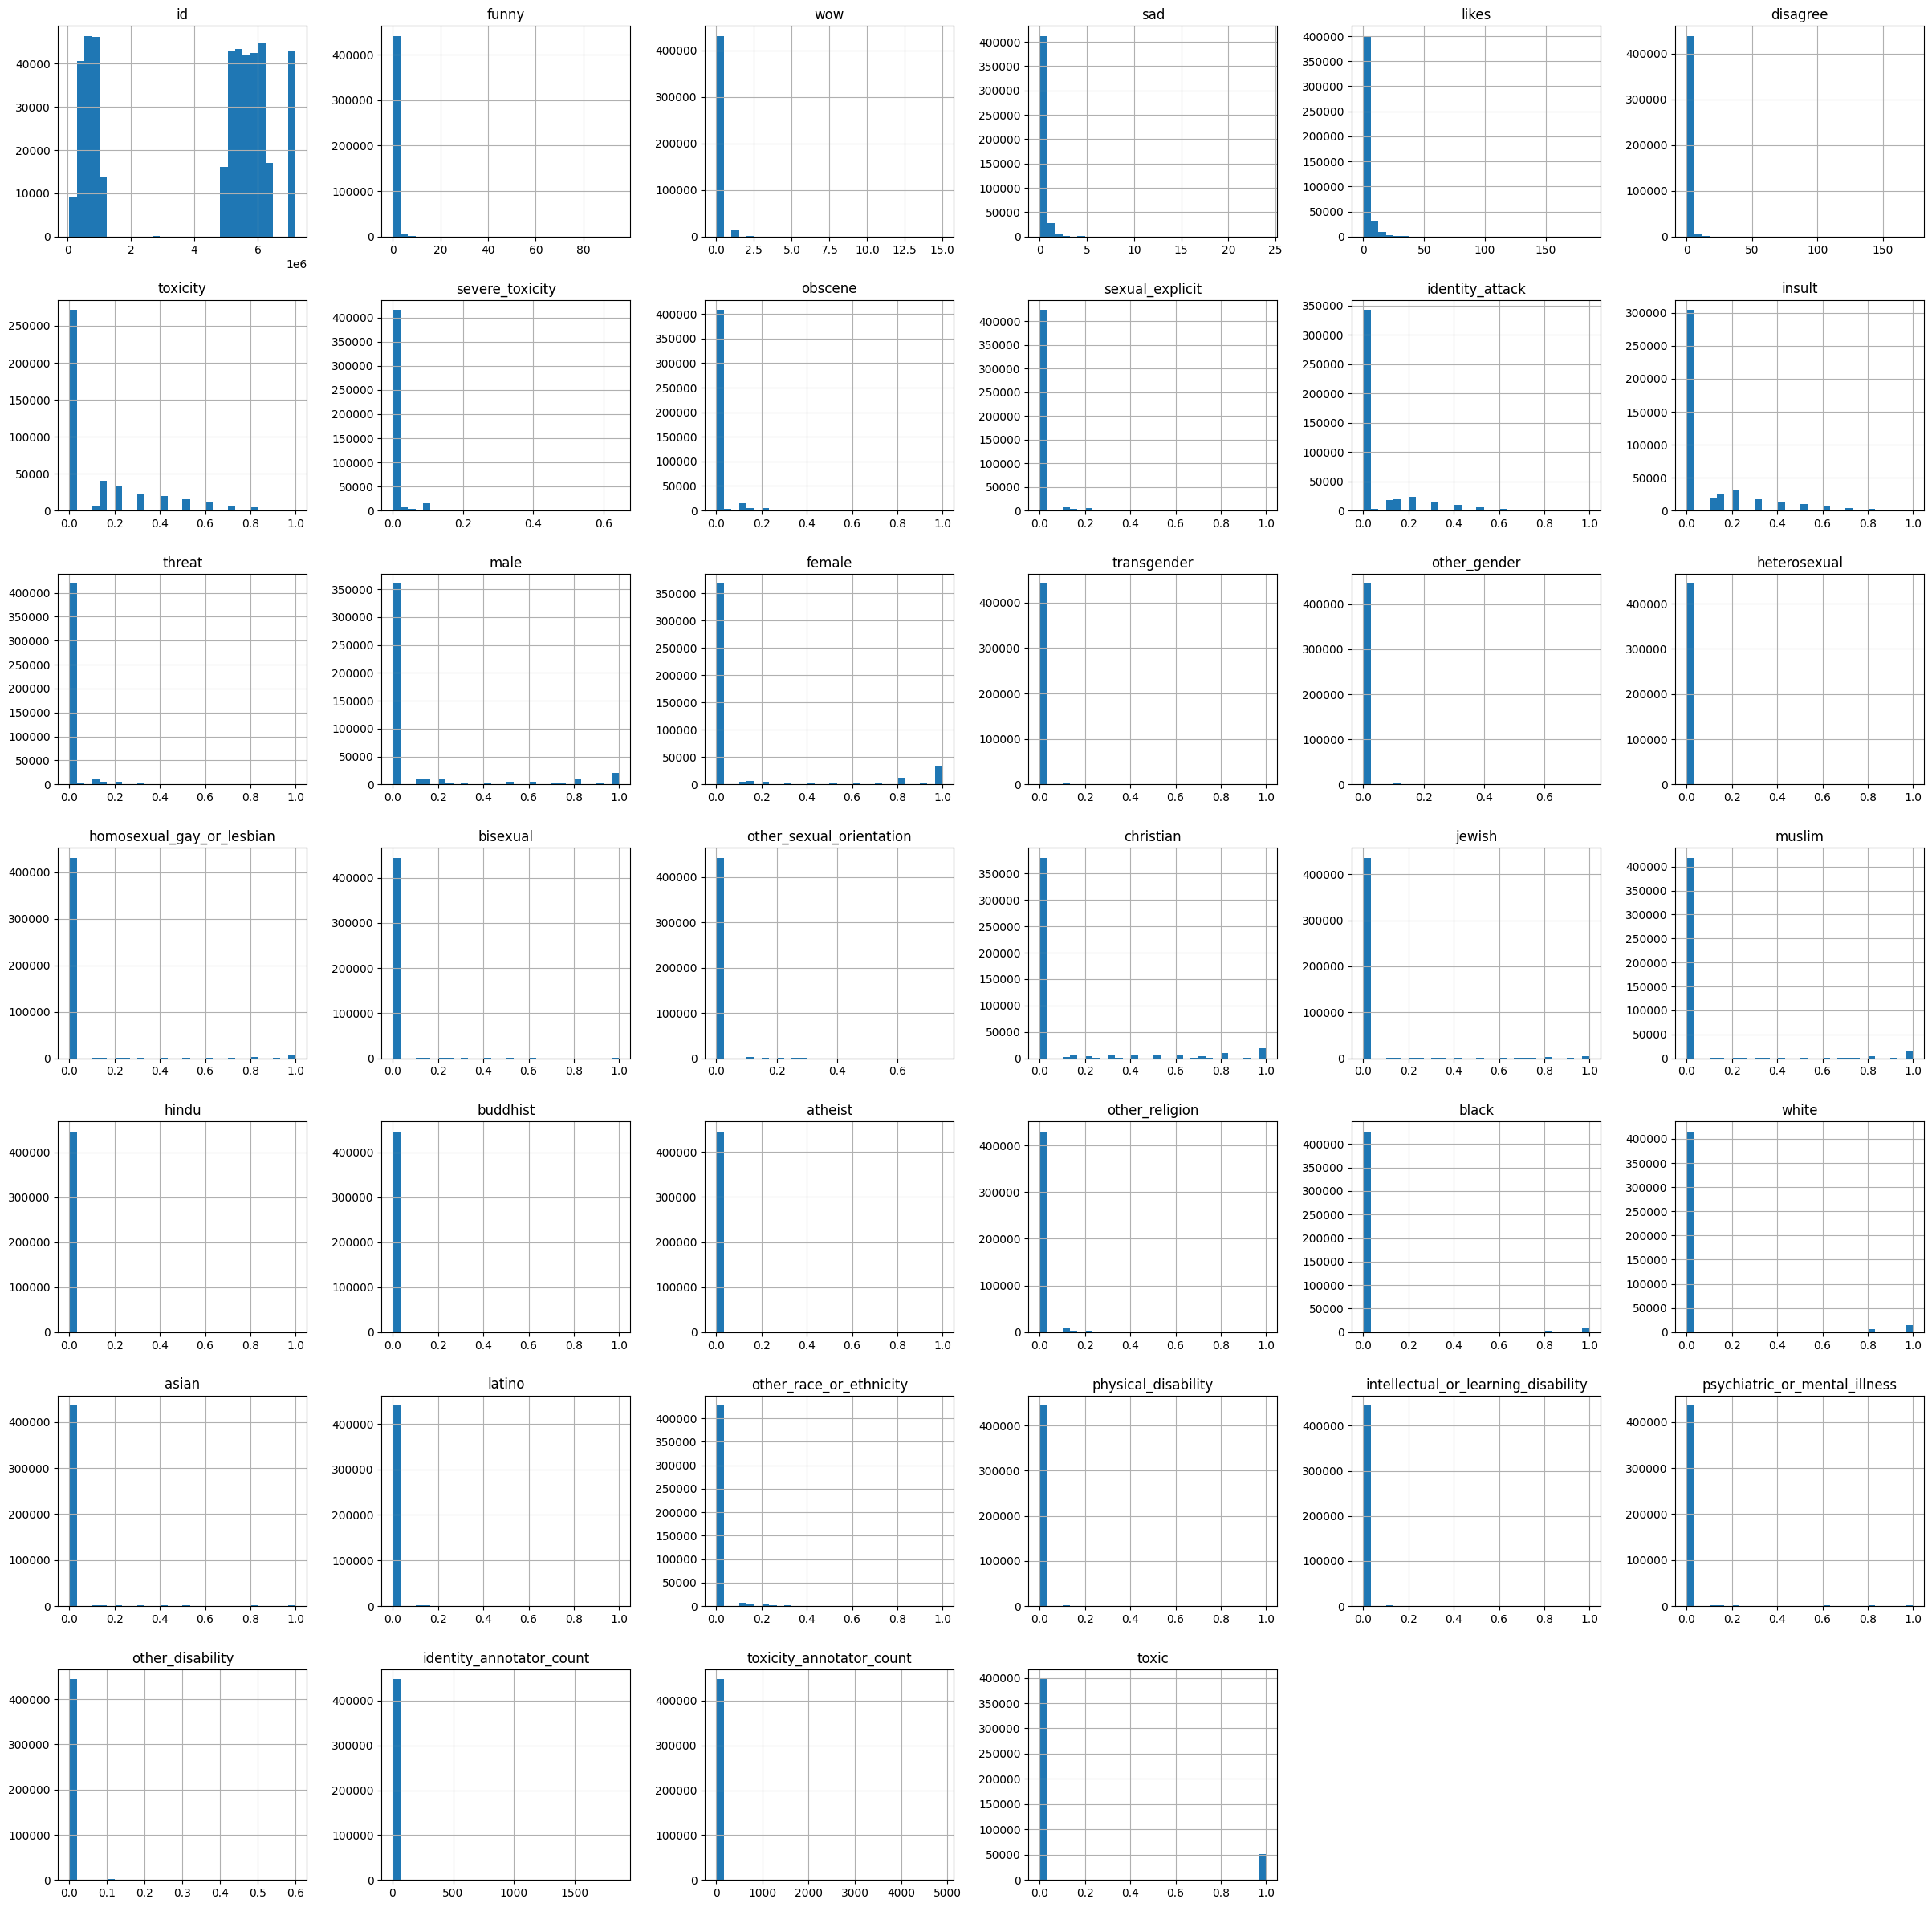

In [15]:
df.hist(bins=30, figsize=(30, 30));

### Calculate percentage for each identity

In [16]:
# create new binary identity features/columns (1 if value >= 0.5)
bin_identity_cols = []
for identity in identity_cols:
    new_col = 'is_' + identity
    df[new_col] = (df[identity] >= 0.5).astype(int)
    bin_identity_cols.append(new_col)

print('# of identity columns:', len(identity_cols))
print('# of new binary identity columns:', len(bin_identity_cols))

# of identity columns: 24
# of new binary identity columns: 24


In [17]:
# calculate percentage for each identity
id_percentages = {}
for identity in bin_identity_cols:
    cnt = df[['id', identity]].groupby(identity).count()['id']
    perc = (cnt[1] / len(df) * 100).round(3)
    id_percentages[identity] = perc

print(id_percentages)

{'is_male': 10.909, 'is_female': 13.077, 'is_transgender': 0.616, 'is_other_gender': 0.002, 'is_heterosexual': 0.32, 'is_homosexual_gay_or_lesbian': 2.692, 'is_bisexual': 0.072, 'is_other_sexual_orientation': 0.002, 'is_christian': 9.966, 'is_jewish': 1.894, 'is_muslim': 5.144, 'is_hindu': 0.141, 'is_buddhist': 0.143, 'is_atheist': 0.378, 'is_other_religion': 0.079, 'is_black': 3.665, 'is_white': 6.146, 'is_asian': 1.123, 'is_latino': 0.498, 'is_other_race_or_ethnicity': 0.123, 'is_physical_disability': 0.02, 'is_intellectual_or_learning_disability': 0.026, 'is_psychiatric_or_mental_illness': 1.205, 'is_other_disability': 0.001}


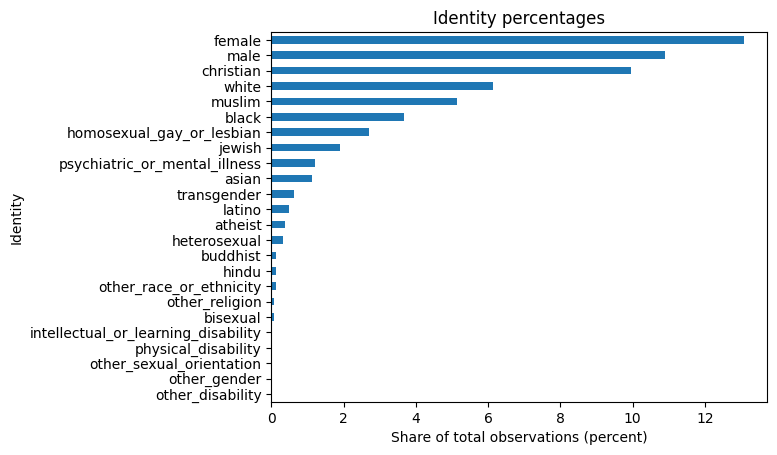

In [18]:
# transform dict into Pandas Series
id_perc_ser = pd.Series(id_percentages).sort_values()

# drop 'is_' from index labels
id_perc_ser.rename(lambda x: x.replace('is_', ''), inplace=True)

# plot
id_perc_ser.plot.barh()
plt.title('Identity percentages')
plt.xlabel('Share of total observations (percent)')
plt.ylabel('Identity');

## Visualisations (Eric)

### WordCloud (toxic comments)

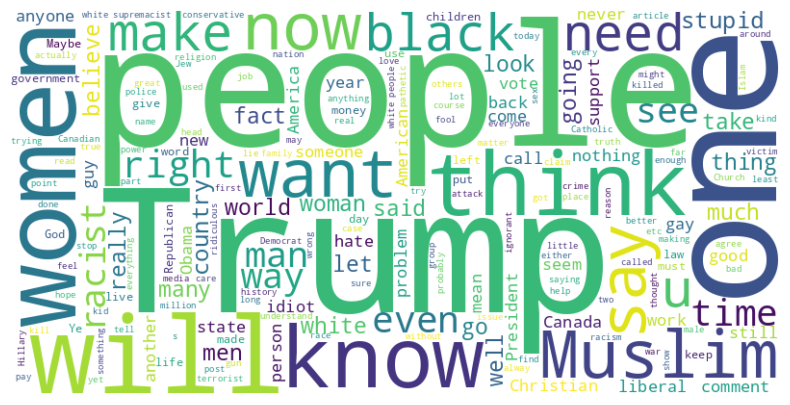

In [19]:
# dataframe with only text and target
df_only_text = df[['comment_text','toxic']]

toxic_comments = df_only_text[df_only_text['toxic'] == 1]['comment_text']
nontoxic_comments = df_only_text[df_only_text['toxic'] == 0]['comment_text']

wordcloud = WordCloud(width=800, height=400, background_color='white')\
    .generate("".join(toxic_comments))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off'); # semicolon suppresses ugly line of code over plot

### WordCloud (non-toxic comments)

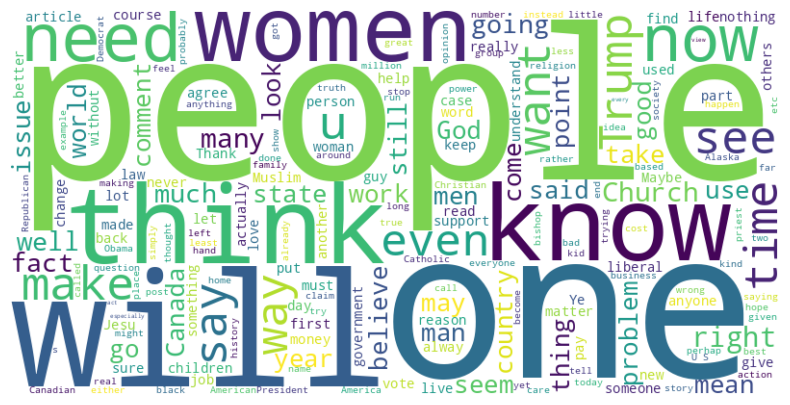

In [20]:
wordcloud_non_toxic = WordCloud(width=800, height=400,
    background_color='white')\
    .generate("".join(nontoxic_comments))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off');

### Word frequency analysis

#### Tokenize comments

In [21]:
toxic_tokens = toxic_comments.apply(word_tokenize)
nontoxic_tokens = nontoxic_comments.apply(word_tokenize)

toxic_tokens[0]

['OH',
 'yes',
 '-',
 'Were',
 'those',
 'evil',
 'Christian',
 'Missionaries',
 '(',
 'many',
 'of',
 'whom',
 'were',
 'slaughtered',
 'by',
 'the',
 'Indians',
 ',',
 'or',
 'lost',
 'their',
 'lives',
 'due',
 'to',
 'disease',
 ',',
 'starvation',
 'etc',
 '.',
 ')',
 'lumped',
 'in',
 'with',
 'those',
 '``',
 'genocidists',
 "''",
 'you',
 'mention',
 '?',
 '(',
 'yes',
 'I',
 'did',
 'make',
 'up',
 'a',
 'word',
 ',',
 'just',
 'as',
 'you',
 'make',
 'up',
 'stories',
 ')',
 '.']

#### Remove punctuation

Filter out non-alphabetical tokens.

In [22]:
toxic_tokens = toxic_tokens.apply(
    lambda x: [word for word in x if word.isalpha()])
nontoxic_tokens = nontoxic_tokens.apply(
    lambda x: [word for word in x if word.isalpha()])

toxic_tokens[0]

['OH',
 'yes',
 'Were',
 'those',
 'evil',
 'Christian',
 'Missionaries',
 'many',
 'of',
 'whom',
 'were',
 'slaughtered',
 'by',
 'the',
 'Indians',
 'or',
 'lost',
 'their',
 'lives',
 'due',
 'to',
 'disease',
 'starvation',
 'etc',
 'lumped',
 'in',
 'with',
 'those',
 'genocidists',
 'you',
 'mention',
 'yes',
 'I',
 'did',
 'make',
 'up',
 'a',
 'word',
 'just',
 'as',
 'you',
 'make',
 'up',
 'stories']

#### Convert to lower case
To ensure uniformity we have to convert all words to lower case.

In [23]:
toxic_tokens = toxic_tokens.apply(lambda x: [word.lower() for word in x])
nontoxic_tokens = nontoxic_tokens.apply(lambda x: [word.lower() for word in x])

toxic_tokens[0]

['oh',
 'yes',
 'were',
 'those',
 'evil',
 'christian',
 'missionaries',
 'many',
 'of',
 'whom',
 'were',
 'slaughtered',
 'by',
 'the',
 'indians',
 'or',
 'lost',
 'their',
 'lives',
 'due',
 'to',
 'disease',
 'starvation',
 'etc',
 'lumped',
 'in',
 'with',
 'those',
 'genocidists',
 'you',
 'mention',
 'yes',
 'i',
 'did',
 'make',
 'up',
 'a',
 'word',
 'just',
 'as',
 'you',
 'make',
 'up',
 'stories']

#### Remove stopwords
This will remove common words like: this, is, and, the, etc.

In [24]:
stop_words = set(stopwords.words('english'))
                         
# stop_words contains a list of 179 words that we want to remove from our
# comments

toxic_tokens = toxic_tokens.apply(
    lambda x: [word for word in x if word not in stop_words])
nontoxic_tokens = nontoxic_tokens.apply(
    lambda x: [word for word in x if word not in stop_words])

toxic_tokens[0]

['oh',
 'yes',
 'evil',
 'christian',
 'missionaries',
 'many',
 'slaughtered',
 'indians',
 'lost',
 'lives',
 'due',
 'disease',
 'starvation',
 'etc',
 'lumped',
 'genocidists',
 'mention',
 'yes',
 'make',
 'word',
 'make',
 'stories']

#### Lemmatization
Lemmatization reduces words to their base or dictionary form. It's usually more sophisticated than stemming.


In [52]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    lemmatized = []
    for word in tokens:
        lemmatized.append(lemmatizer.lemmatize(word, pos=wordnet.VERB))
    return lemmatized

toxic_tokens = toxic_tokens.apply(lemmatize_tokens)
nontoxic_tokens = nontoxic_tokens.apply(lemmatize_tokens)

toxic_tokens[0]

['oh',
 'ye',
 'evil',
 'christian',
 'missionari',
 'mani',
 'slaughter',
 'indian',
 'lose',
 'live',
 'due',
 'diseas',
 'starvat',
 'etc',
 'lump',
 'genocidist',
 'mention',
 'ye',
 'make',
 'word',
 'make',
 'stori']

#### Create flat token list

In [53]:
flat_token_list = []
for sublist in toxic_tokens:
    for token in sublist:
        flat_token_list.append(token)

len(flat_token_list)

1434164

### Token frequency (line plot)

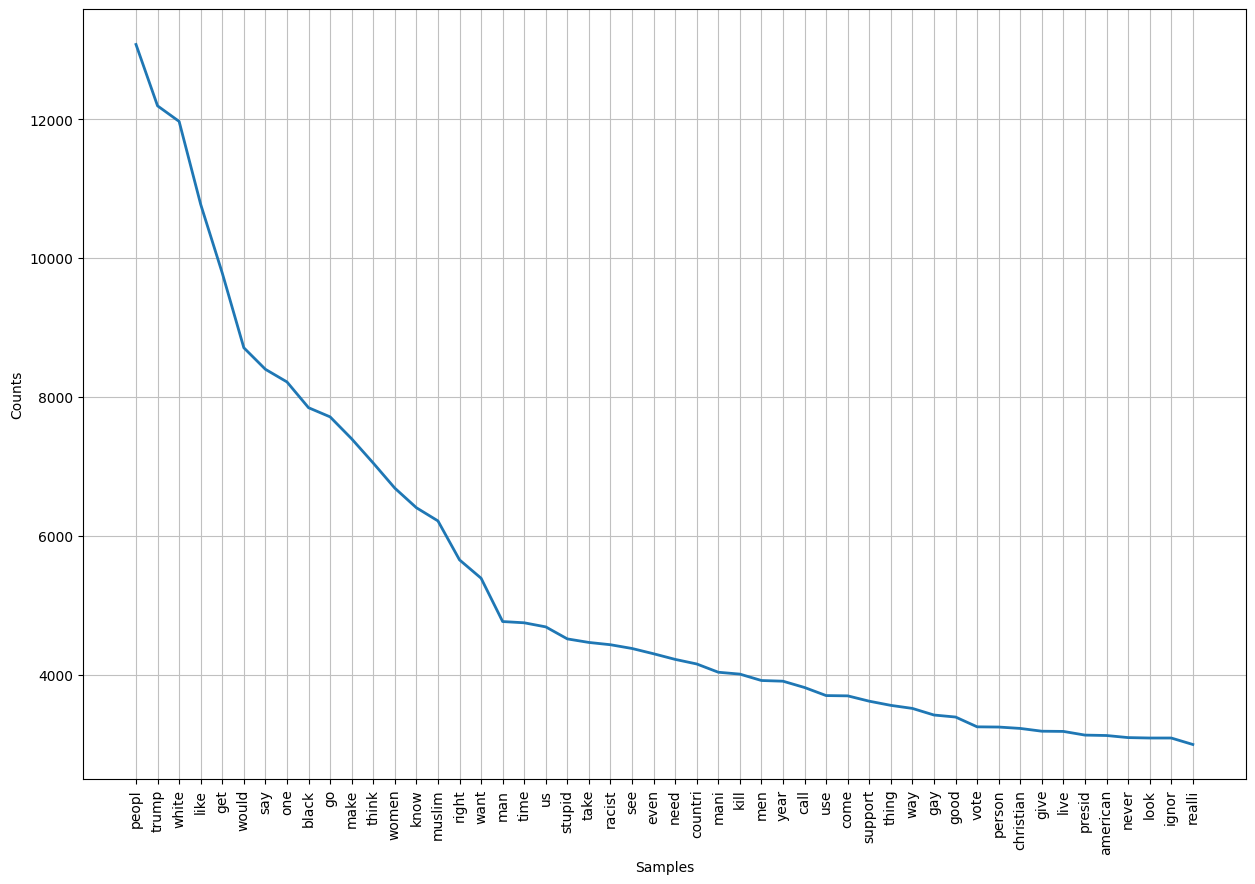

In [54]:
fdist = FreqDist(flat_token_list)

plt.figure(figsize=(15, 10))
fdist.plot(50, cumulative=False);

### Token frequency top 20 (bar plot with highlighted bars)

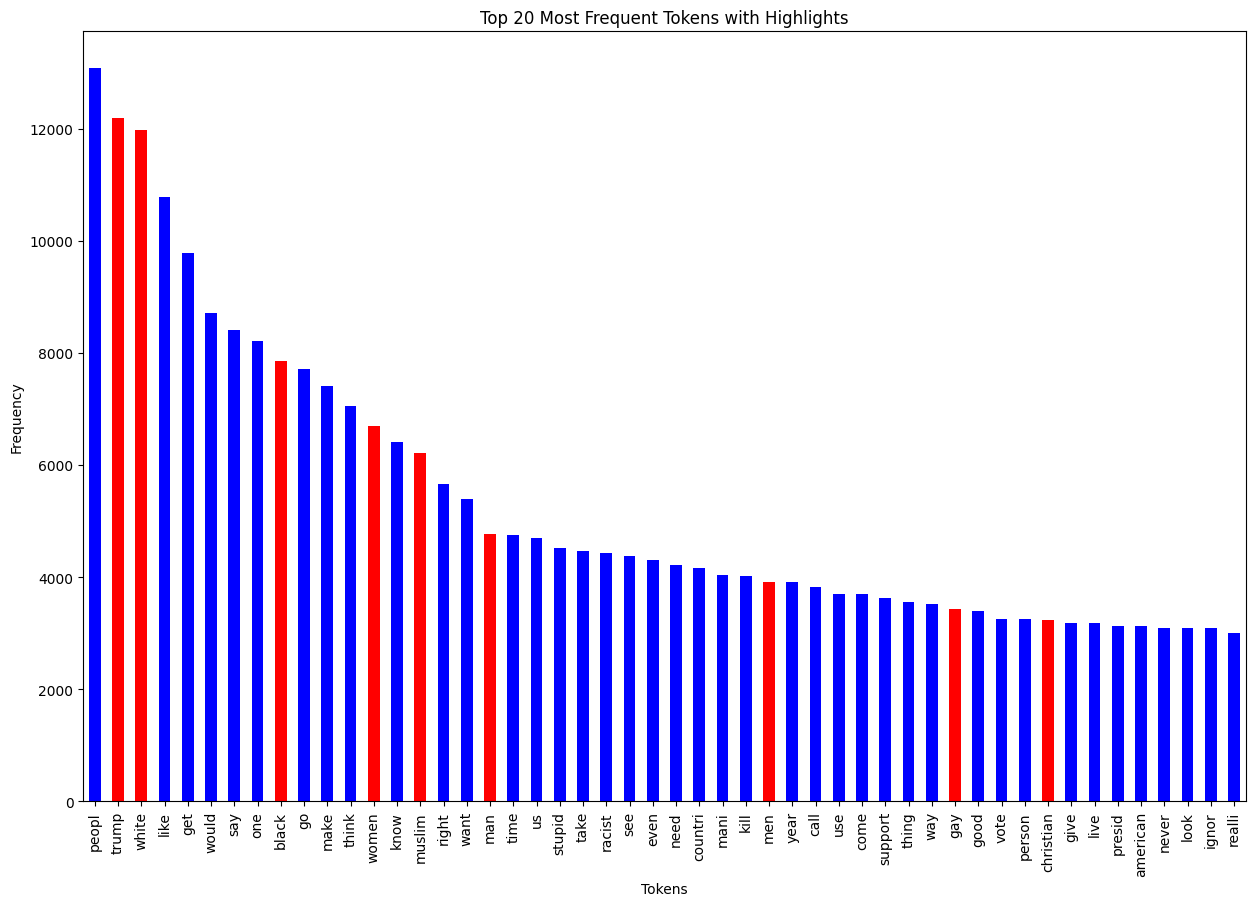

In [55]:
word_counts = pd.DataFrame(flat_token_list, columns=['word'])['word']\
    .value_counts()\
    .head(50)

# define words to highlight
highlight = ['black', 'women', 'man', 'trump', 'white', 'muslim',
             'men', 'gay', 'christian']

# create color array
colors = ['red' if word in highlight else 'blue' for word in word_counts.index]

# plot bar chart
plt.figure(figsize=(15, 10))
word_counts.plot(kind='bar', color=colors)
plt.title('Top 20 Most Frequent Tokens with Highlights')
plt.ylabel('Frequency')
plt.xlabel('Tokens')
plt.xticks(rotation=90);

The frequent use of words like 'Trump,' 'white,' and 'black' in the top ten most common words on toxic comments indicates that the data was gathered during a highly charged and divisive political period in the U.S. This pattern points to social media being a key venue for expressing deeply polarized views and racially motivated hate speech

Also, other identities like woman, Muslim,  gay, and Christian were among the most frequently used words when writing a toxic comment.

### N-gram analysis

#### Create n-grams

In [56]:
# Generate bi-grams (2-grams)
bi_grams = ngrams(flat_token_list, 2)
bi_gram_counts = Counter(bi_grams)

# Generate tri-grams (3-grams)
tri_grams = ngrams(flat_token_list, 3)
tri_gram_counts = Counter(tri_grams)

#### Print top 10 n-grams

In [57]:
# Print the 10 most common bi-grams
print("Most Common Bi-grams:")
for gram, count in bi_gram_counts.most_common(10):
    print(f"{gram}: {count}")

# Print the 10 most common tri-grams
print("\nMost Common Tri-grams:")
for gram, count in tri_gram_counts.most_common(10):
    print(f"{gram}: {count}")

Most Common Bi-grams:
('white', 'supremacist'): 1473
('white', 'peopl'): 1194
('mental', 'ill'): 786
('donald', 'trump'): 786
('black', 'peopl'): 735
('look', 'like'): 592
('white', 'men'): 526
('white', 'male'): 488
('sexual', 'assault'): 488
('white', 'hous'): 470

Most Common Tri-grams:
('black', 'live', 'matter'): 335
('sexual', 'assault', 'women'): 93
('make', 'america', 'great'): 89
('nazi', 'white', 'supremacist'): 86
('presid', 'unit', 'state'): 77
('ha', 'ha', 'ha'): 75
('racist', 'white', 'supremacist'): 70
('could', 'care', 'less'): 69
('lisa', 'bloom', 'also'): 61
('liber', 'mental', 'disord'): 57


#### Plot top 10 n-grams

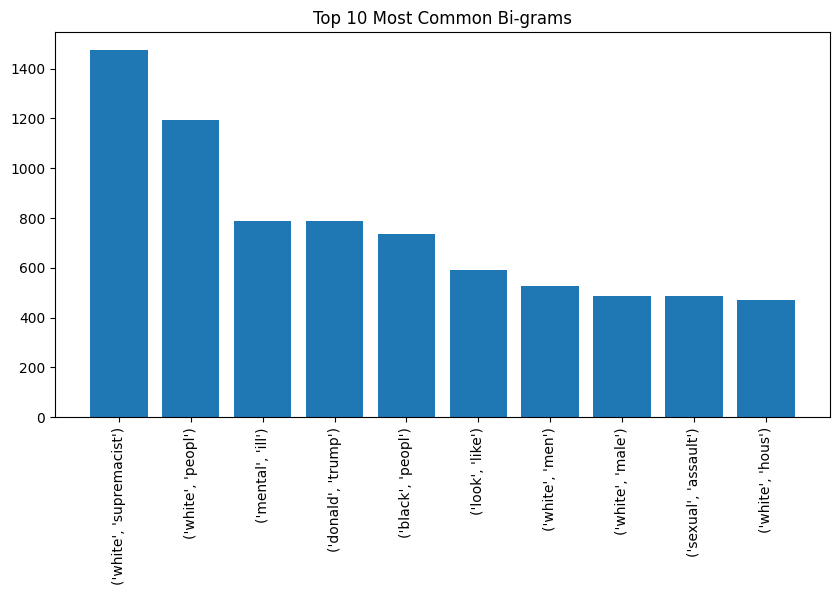

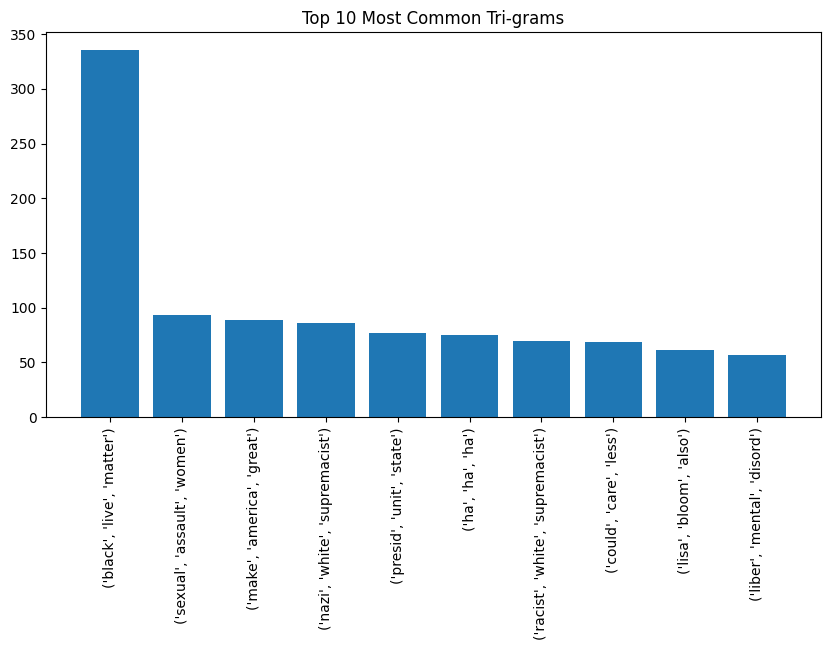

In [59]:
# Convert the bi-gram and tri-gram counts to DataFrames
df_bi_grams = pd.DataFrame(bi_gram_counts.most_common(10),
                           columns=['bi_gram', 'count'])
df_tri_grams = pd.DataFrame(tri_gram_counts.most_common(10),
                            columns=['tri_gram', 'count'])

# Plot bi-grams
plt.figure(figsize=(10, 5))
plt.bar(df_bi_grams['bi_gram'].astype(str), df_bi_grams['count'])
plt.title('Top 10 Most Common Bi-grams')
plt.xticks(rotation=90)

# Plot tri-grams
plt.figure(figsize=(10, 5))
plt.bar(df_tri_grams['tri_gram'].astype(str), df_tri_grams['count'])
plt.title('Top 10 Most Common Tri-grams')
plt.xticks(rotation=90);


Also, the Bi-Grams and Tri-Grams Analysis indicates a strong correlation with public awareness and social mobilization 
triggered by the Black Lives Matter movement following the murder of Michael Brown

### Results

- Our EDA reveals a marked increase in online discussions and polarized sentiments around race-related topics during 2015-2017, mirroring the heightened public awareness and social mobilization triggered by the Black Lives Matter movement following the murder of Michael Brown. Source:https://sites.suffolk.edu/jhtl/2020/09/25/more-than-just-a-hashtag-the-influence-of-social-media-on-the-societal-change-of-the-black-lives-matter-movement/
- The data shows a significant uptick in political polarization on social media platforms coinciding with the 2016 U.S. Presidential Election, reflecting the deep societal divisions and contentious political discourse prevalent during this period. Sources:  https://www.cato.org/research-briefs-economic-policy/internet-political-polarization-2016-election
- An observable surge in racially charged content and discussions on social media aligns with the Charleston church shooting in 2015, underscoring the incident's profound impact on national conversations about race relations and systemic racism in the United States. https://en.wikipedia.org/wiki/Charleston_church_shooting

## Visualisations (Purvi)

### Correlation heatmaps

In [33]:
toxic_data = df[df['toxic'] == 1] # toxic data have values where toxic = 1

In [60]:
# Correlation heatmap using toxic = 1 and columns >= 0.5

t_gend = (toxic_data[gender_cols].values >= 0.5).any(axis=1)
corr_gender = toxic_data.loc[t_gend, gender_cols + ['toxicity']]

t_race = (toxic_data[race_cols].values >= 0.5).any(axis=1)
corr_race = toxic_data.loc[t_race, race_cols + ['toxicity']]

t_rel = (toxic_data[religion_cols].values >= 0.5).any(axis=1)
corr_rel = toxic_data.loc[t_rel, religion_cols + ['toxicity']]

@Purvi:  
Just a suggestion: Should we hide the "upper triangle" above the main diagonal? I feel that the chart becomes more readable this way. Maybe you want/can look into that if you have time.

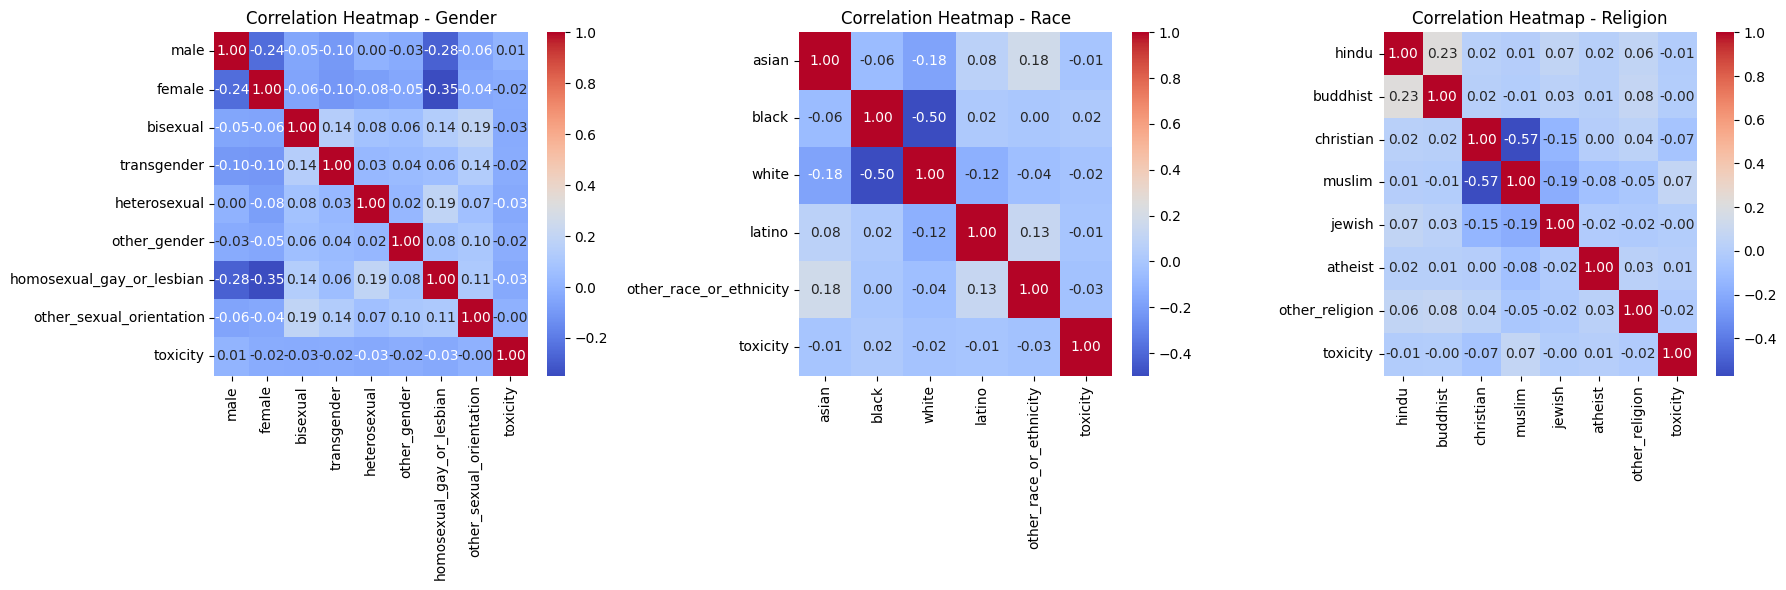

In [35]:
# Calculate correlations
corr_gender_matrix = corr_gender.corr()
corr_race_matrix = corr_race.corr()
corr_rel_matrix = corr_rel.corr()

# Create subplot for each heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot correlation heatmaps
sns.heatmap(corr_gender_matrix, annot=True, cmap='coolwarm',
            fmt='.2f', ax=axes[0])
axes[0].set_title('Correlation Heatmap - Gender')

sns.heatmap(corr_race_matrix, annot=True, cmap='coolwarm',
            fmt='.2f', ax=axes[1])
axes[1].set_title('Correlation Heatmap - Race')

sns.heatmap(corr_rel_matrix, annot=True, cmap='coolwarm',
            fmt='.2f', ax=axes[2])
axes[2].set_title('Correlation Heatmap - Religion')

plt.tight_layout()

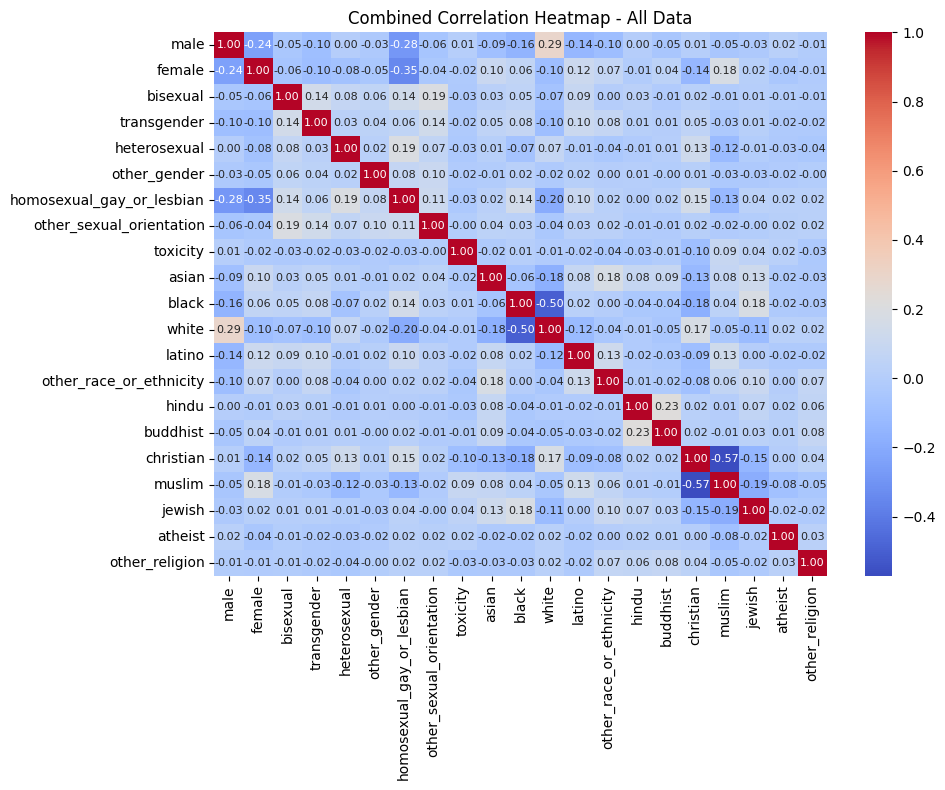

In [36]:
#correlation for all columns together
corr_gender_all = toxic_data.loc[t_gend, gender_cols + ['toxicity']]
corr_race_all = toxic_data.loc[t_race, race_cols]
corr_rel_all = toxic_data.loc[t_rel, religion_cols]

all_data = pd.concat([corr_gender_all, corr_race_all, corr_rel_all], axis=1)

# Calculate overall correlation matrix
corr_all_data = all_data.corr()

# Plot combined correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_all_data, annot=True, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 8})
plt.title('Combined Correlation Heatmap - All Data')

plt.tight_layout()
#plt.savefig('corr')

### Mean toxicity for identity subgroups (all values taken into account)

In [37]:
#  gender columns
mean_gender = df[gender_cols].mean()

# race columns
mean_race = df[race_cols].mean()

# religion columns
mean_religion = df[religion_cols].mean()

# Print means
print("Mean of Gender Columns:")
print(mean_gender)

print("\nMean of Race Columns:")
print(mean_race)

print("\nMean of Religion Columns:")
print(mean_religion)

Mean of Gender Columns:
male                         0.108047
female                       0.126652
bisexual                     0.001893
transgender                  0.006712
heterosexual                 0.003248
other_gender                 0.000882
homosexual_gay_or_lesbian    0.025378
other_sexual_orientation     0.001492
dtype: float64

Mean of Race Columns:
asian                      0.011886
black                      0.034276
white                      0.056535
latino                     0.006151
other_race_or_ethnicity    0.008158
dtype: float64

Mean of Religion Columns:
hindu             0.001443
buddhist          0.001393
christian         0.095184
muslim            0.049078
jewish            0.017910
atheist           0.003468
other_religion    0.006718
dtype: float64


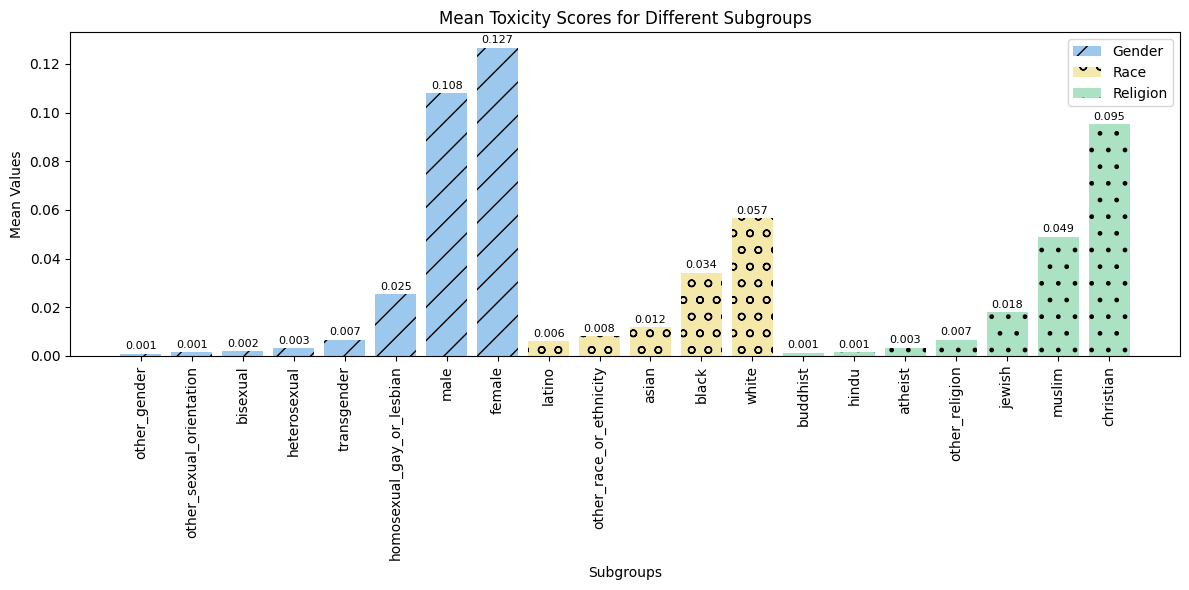

In [38]:
mean_gender = {
    'male': 0.108047,
    'female': 0.126652,
    'bisexual': 0.001893,
    'transgender': 0.006712,
    'heterosexual': 0.003248,
    'other_gender': 0.000882,
    'homosexual_gay_or_lesbian': 0.025378,
    'other_sexual_orientation': 0.001492
}

mean_race = {
    'asian': 0.011886,
    'black': 0.034276,
    'white': 0.056535,
    'latino': 0.006151,
    'other_race_or_ethnicity': 0.008158
}

mean_religion = {
    'hindu': 0.001443,
    'buddhist': 0.001393,
    'christian': 0.095184,
    'muslim': 0.049078,
    'jewish': 0.017910,
    'atheist': 0.003468,
    'other_religion': 0.006718
}

mean_gender_sorted1 = dict(sorted(mean_gender.items(),
                                  key=lambda item: item[1]))
mean_race_sorted1 = dict(sorted(mean_race.items(),
                                key=lambda item: item[1]))
mean_religion_sorted1 = dict(sorted(mean_religion.items(),
                                    key=lambda item: item[1]))

plt.figure(figsize=(12, 6))

plt.bar(mean_gender_sorted1.keys(), mean_gender_sorted1.values(),
        label='Gender', color='#9CC8ED', hatch='/')
plt.bar(mean_race_sorted1.keys(), mean_race_sorted1.values(),
        label='Race', color='#F4E8AB', hatch='o')
plt.bar(mean_religion_sorted1.keys(), mean_religion_sorted1.values(),
        label='Religion', color='#AAE2C3', hatch='.')

plt.xlabel('Subgroups')
plt.ylabel('Mean Values')
plt.title('Mean Toxicity Scores for Different Subgroups')
plt.xticks(rotation=90)
plt.legend()

# Adding data labels to each bar
for data in [mean_gender_sorted1, mean_race_sorted1, mean_religion_sorted1]:
    for subgroup, value in data.items():
        plt.text(subgroup, value + 0.001, round(value, 3), ha='center', va='bottom', fontsize=8)

plt.tight_layout()

### Mean toxicity for identity subgroups (just values >= 0.5)

@Purvi:  
This plot IMO makes more sense than the previous one. Maybe drop previous?

In [39]:
mean_toxic_gender = toxic_data[gender_cols]\
    .apply(lambda x: x[x >= 0.5].mean())
mean_toxic_race = toxic_data[race_cols]\
    .apply(lambda x: x[x >= 0.5].mean())
mean_toxic_religion = toxic_data[religion_cols]\
    .apply(lambda x: x[x >= 0.5].mean())

# print means

print("Mean of Gender Columns (>= 0.5 where toxic is 1):")
print(mean_toxic_gender)

print("\nMean of Race Columns (>= 0.5 where toxic is 1):")
print(mean_toxic_race)

print("\nMean of Religion Columns (>= 0.5 where toxic is 1):")
print(mean_toxic_religion)

Mean of Gender Columns (>= 0.5 where toxic is 1):
male                         0.832137
female                       0.890529
bisexual                     0.683539
transgender                  0.821347
heterosexual                 0.747159
other_gender                 0.533333
homosexual_gay_or_lesbian    0.878025
other_sexual_orientation     0.533333
dtype: float64

Mean of Race Columns (>= 0.5 where toxic is 1):
asian                      0.758636
black                      0.898275
white                      0.896285
latino                     0.729187
other_race_or_ethnicity    0.567602
dtype: float64

Mean of Religion Columns (>= 0.5 where toxic is 1):
hindu             0.762626
buddhist          0.731650
christian         0.864552
muslim            0.905658
jewish            0.896070
atheist           0.847757
other_religion    0.528125
dtype: float64


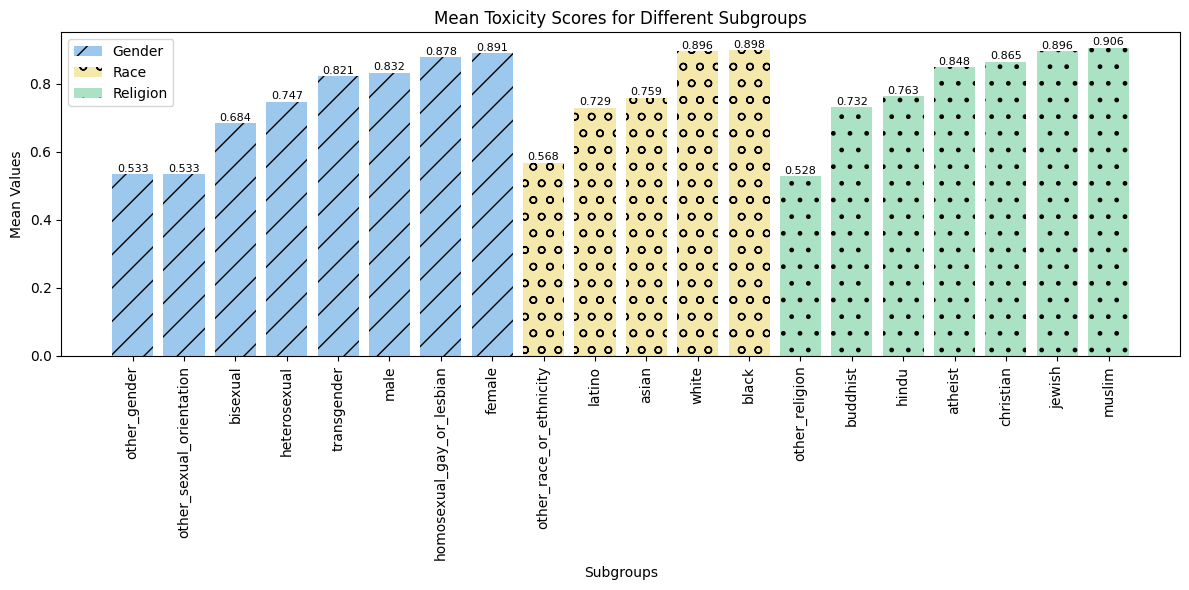

In [40]:
mean_gender = {
    'male': 0.832137,
    'female': 0.890529,
    'bisexual': 0.683539,
    'transgender': 0.821347,
    'heterosexual': 0.747159,
    'other_gender': 0.533333,
    'homosexual_gay_or_lesbian': 0.878025,
    'other_sexual_orientation': 0.533333
}

mean_race = {
    'asian': 0.758636,
    'black': 0.898275,
    'white': 0.896285,
    'latino': 0.729187,
    'other_race_or_ethnicity': 0.567602
}

mean_religion = {
    'hindu': 0.762626,
    'buddhist': 0.731650,
    'christian': 0.864552,
    'muslim': 0.905658,
    'jewish': 0.896070,
    'atheist': 0.847757,
    'other_religion': 0.528125
}

# sort in ascending order

mean_gender_sorted = dict(sorted(mean_gender.items(),
                                 key=lambda item: item[1]))
mean_race_sorted = dict(sorted(mean_race.items(),
                               key=lambda item: item[1]))
mean_religion_sorted = dict(sorted(mean_religion.items(),
                                   key=lambda item: item[1]))

# plot

plt.figure(figsize=(12, 6))

plt.bar(mean_gender_sorted.keys(), mean_gender_sorted.values(),
        label='Gender', color='#9CC8ED', hatch='/')
plt.bar(mean_race_sorted.keys(), mean_race_sorted.values(),
        label='Race', color='#F4E8AB', hatch='o')
plt.bar(mean_religion_sorted.keys(), mean_religion_sorted.values(),
        label='Religion', color='#AAE2C3', hatch='.')

plt.xlabel('Subgroups')
plt.ylabel('Mean Values')
plt.title('Mean Toxicity Scores for Different Subgroups')
plt.xticks(rotation=90)
plt.legend()

# Add data labels to each bar
for data in [mean_gender, mean_race, mean_religion]:
    for subgroup, value in data.items():
        plt.text(subgroup, value + 0.001, round(value, 3), ha='center',
                 va='bottom', fontsize=8)

plt.tight_layout()

#plt.savefig('mean_toxicity.png')

### Word frequency for identity subgroups

In [41]:
toxic_gender = toxic_data.loc[t_gend, gender_cols + ['comment_text']]
toxic_race = toxic_data.loc[t_race, race_cols + ['comment_text']]
toxic_religion = toxic_data.loc[t_rel, religion_cols + ['comment_text']]

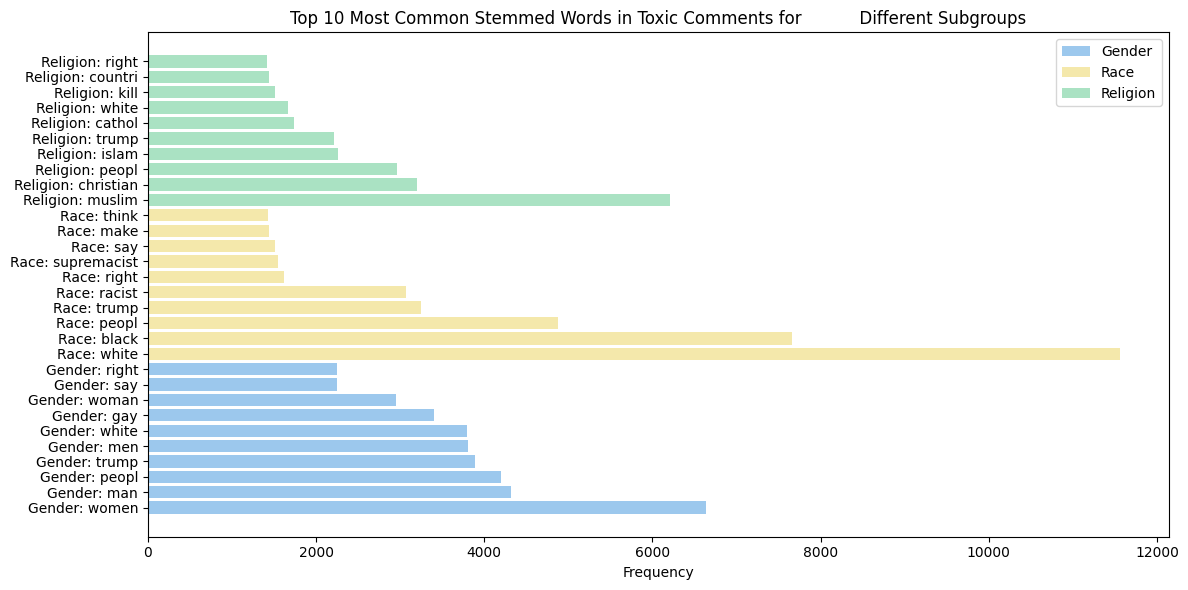

In [42]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

def most_common_words(data):
    stop_words = set(stopwords.words('english'))  

    all_words = ' '.join(data['comment_text']).lower()
    
    # patterns to remove
    additional_exclusions = ['’', '...', 's', "n't", 'get', 'one', 'would']  
    
    # remove punctuations
    pattern = re.compile(r'[^\w\s]')
    
    words = word_tokenize(all_words)
    # Remove stopwords, punctuation, and apply stemming
    filtered_words = [
        stemmer.stem(word)
        for word in words
        if word not in stop_words
        and word not in string.punctuation
        and word not in additional_exclusions
        and word not in ['like']  # Exclude specific word 'like'
        and not pattern.match(word)
    ]
    words_count = Counter(filtered_words)
    return words_count.most_common(10)  # Get the 10 most common words

# Get the most common stemmed words for each subgroup
most_common_gender = most_common_words(toxic_gender)
most_common_race = most_common_words(toxic_race)
most_common_religion = most_common_words(toxic_religion)

# Prepare data for plotting
common_words = {
    'Gender': most_common_gender,
    'Race': most_common_race,
    'Religion': most_common_religion
}

# Plotting
plt.figure(figsize=(12, 6))
colors = {'Gender': '#9CC8ED', 'Race': '#F4E8AB', 'Religion': '#AAE2C3'}

for subgroup, common_words in common_words.items():
    words, counts = zip(*common_words)
    plt.barh([f'{subgroup}: {word}' for word in words], counts, label=subgroup,color=colors[subgroup])

plt.xlabel('Frequency')
plt.title('Top 10 Most Common Stemmed Words in Toxic Comments for \
          Different Subgroups')
plt.legend()

plt.tight_layout()

#plt.savefig('most_common.png')

## Visualisations (André)

### Ratings: approved vs. rejected (bar plot)

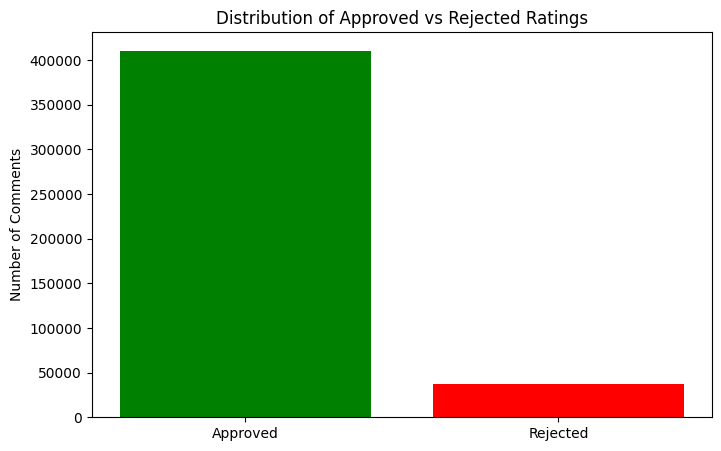

In [43]:
# counting the number of occurences of each identity
counts = df['rating'].value_counts()

# Plotting the distribution of the ratings
plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts.values, color=['green', 'red'])
plt.xticks(counts.index, ['Approved', 'Rejected'])
plt.title('Distribution of Approved vs Rejected Ratings')
plt.ylabel('Number of Comments');

### Analysis of data over time

In [44]:
# copy original df in order to modify it
df_time = df

# @André:
# Not sure: What's the meaning of the 2nd .str in the following line?
# Is it necessary?
df_time['date'] = df_time['created_date'].str.split(' ').str[0]
df_time['date'] = pd.to_datetime(df_time['date'])

# sort df by date
df_time.sort_values(by='date', inplace=True)

#### Toxic comments over time

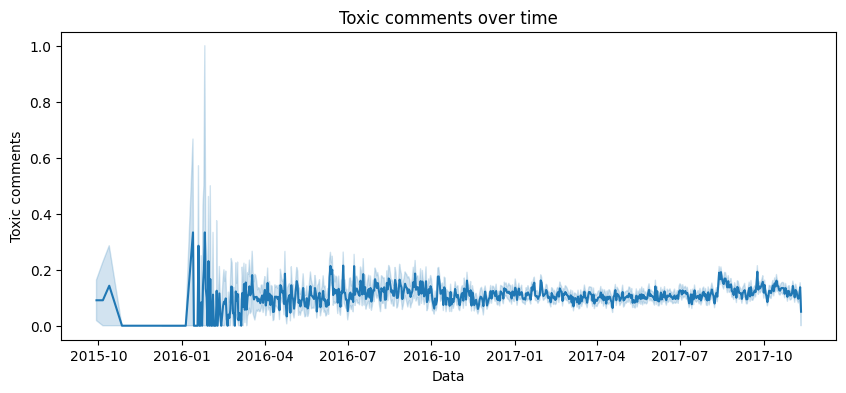

In [45]:
# plot
plt.figure(figsize=(10, 4))
sns.lineplot(x='date', y='toxic', data=df_time)
plt.title('Toxic comments over time')
plt.xlabel('Data')
plt.ylabel('Toxic comments');

#### Daily percentage of toxic comments

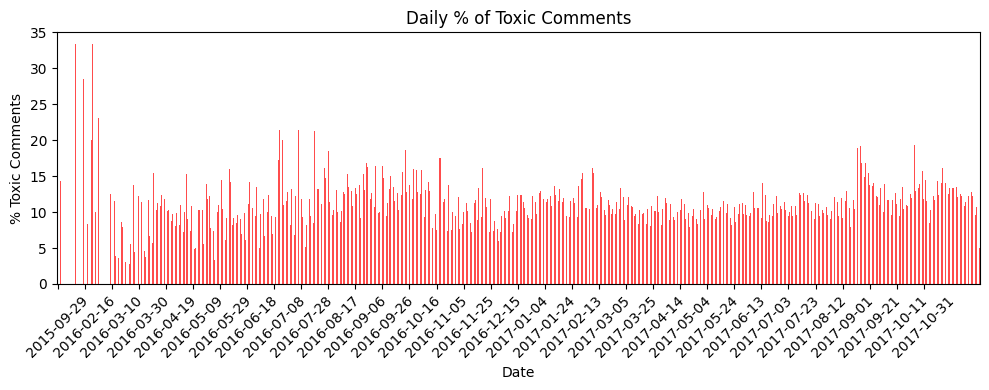

In [46]:
# get only toxic comments per day
daily_toxic_counts = df_time[df_time['toxic'] == 1].groupby('date').size()

# get total comments per day

# @André:
# Just an idea, maybe I'm wrong: Isn't your next line equivalent to
# df_time.groupby('date').size()
# ? Maybe you would like to try it out because it's simpler.

daily_counts = df_time['toxic'].groupby(df_time['date']).size()

# % of toxic comments per day
daily_percentage = (daily_toxic_counts / daily_counts) * 100

# Plot the distribution of toxic comments over time
plt.figure(figsize=(10, 4))
daily_percentage.plot(kind='bar', color='red', alpha=0.7)

# Manually set x-axis labels to display every 7 days
plt.xticks(range(0, len(daily_toxic_counts), 20),
           [str(date.date()) for date in daily_toxic_counts.index[::20]],
           rotation=45)
plt.title('Daily % of Toxic Comments')
plt.xlabel('Date')
plt.ylabel('% Toxic Comments')
plt.tight_layout()

#### Daily total of toxic comments

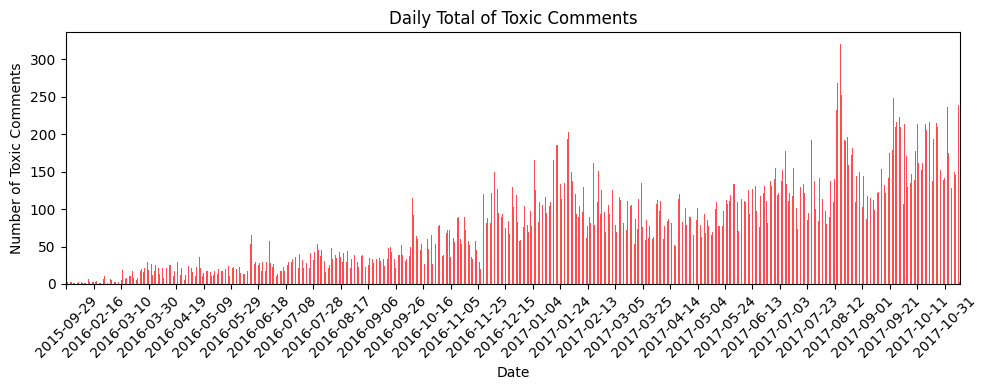

In [47]:
plt.figure(figsize=(10, 4))
daily_toxic_counts.plot(kind='bar', color='red', alpha=0.7)

# Manually set x-axis labels to display every 7 days
plt.xticks(range(0, len(daily_toxic_counts), 20),
           [str(date.date()) for date in daily_toxic_counts.index[::20]],
           rotation=45)
plt.title('Daily Total of Toxic Comments')
plt.xlabel('Date')
plt.ylabel('Number of Toxic Comments')
plt.tight_layout()

### Analysis of reactions (as contained in Civil Comments metadata)
Analyze how users react ('likes' or 'disagree') to toxic vs non-toxic comments. Reactions: 'funny', 'wow', 'sad', 'likes', 'disagree'.

In [48]:
# new df containing just reaction cols
df_react = df.loc[:, ('funny', 'wow', 'sad', 'likes', 'disagree', 'toxic')]

Percentage of comments with any reaction: 68.11%


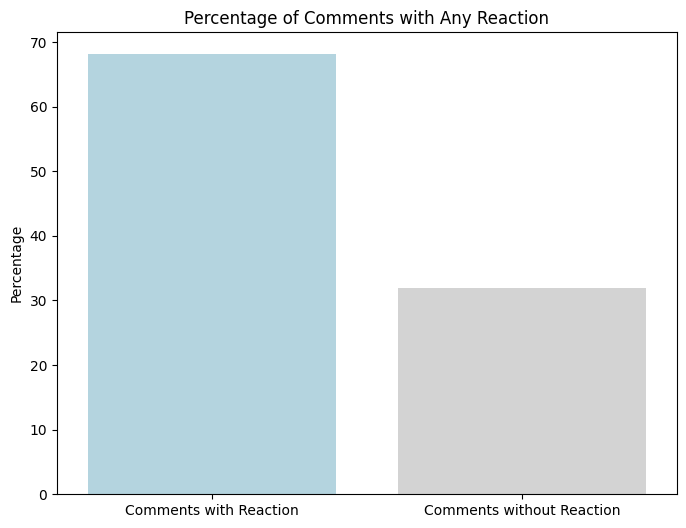

In [49]:
# Calculate the total number of comments with any reaction
df_react['any_reaction'] = (df_react[['funny', 'wow', 'sad',
                                      'likes', 'disagree']] > 0).any(axis=1)
total_comments_with_reaction = df_react['any_reaction'].sum()

# Calculate the percentage of comments with any reaction
percentage_comments_with_reaction =\
    (total_comments_with_reaction / len(df_react)) * 100

# Print the percentage
print(f"Percentage of comments with any reaction: {percentage_comments_with_reaction:.2f}%")

# Plot the percentage
plt.figure(figsize=(8, 6))
sns.barplot(x=['Comments with Reaction', 'Comments without Reaction'],
            y=[percentage_comments_with_reaction,
               100 - percentage_comments_with_reaction],
            palette=['lightblue', 'lightgrey'])
plt.title('Percentage of Comments with Any Reaction')
plt.ylabel('Percentage');

Percentage of comments with reactions by toxicity:
With toxicity: 63.32%
Without toxicity: 36.68%


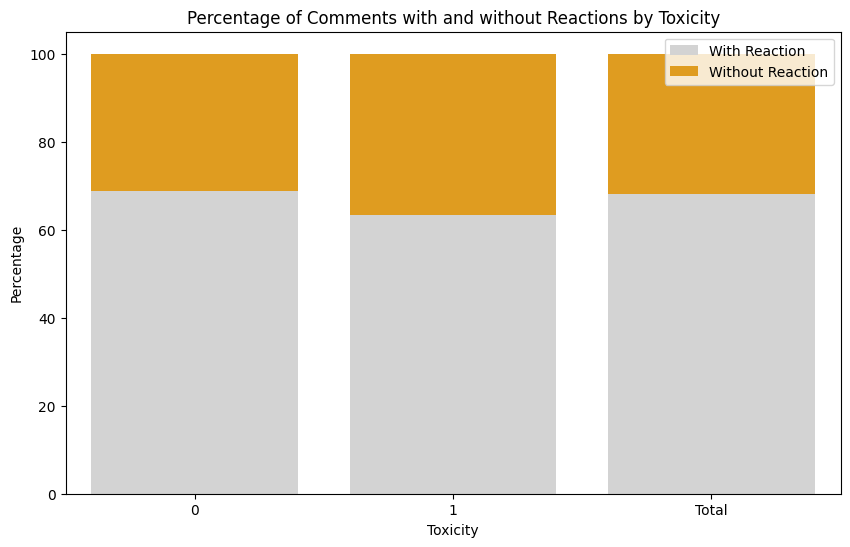

In [50]:
# Calculate the total number of comments with any reaction
df_react['any_reaction'] = (df_react[['funny', 'wow', 'sad',
                                      'likes', 'disagree']] > 0).any(axis=1)

# Create a contingency table to count occurrences
contingency_table = pd.crosstab(df_react['toxic'], df_react['any_reaction'],
                                margins=True, margins_name="Total")

# Calculate percentages
percentage_comments_with_reaction_and_toxic = \
    (contingency_table[True] / contingency_table['Total']) * 100
percentage_comments_without_reaction_and_toxic = \
    (contingency_table[False] / contingency_table['Total']) * 100

# Print percentages
print("Percentage of comments with reactions by toxicity:")
print(f"With toxicity: {percentage_comments_with_reaction_and_toxic[True]:.2f}%")
print(f"Without toxicity: {percentage_comments_without_reaction_and_toxic[True]:.2f}%")

# Plot the percentages
plt.figure(figsize=(10, 6))
sns.barplot(x=contingency_table.index,
            y=percentage_comments_with_reaction_and_toxic, color='lightgray',
            label='With Reaction')
sns.barplot(x=contingency_table.index,
            y=percentage_comments_without_reaction_and_toxic, color='orange',
            label='Without Reaction',
            bottom=percentage_comments_with_reaction_and_toxic)

plt.title('Percentage of Comments with and without Reactions by Toxicity')
plt.xlabel('Toxicity')
plt.ylabel('Percentage')
plt.legend();

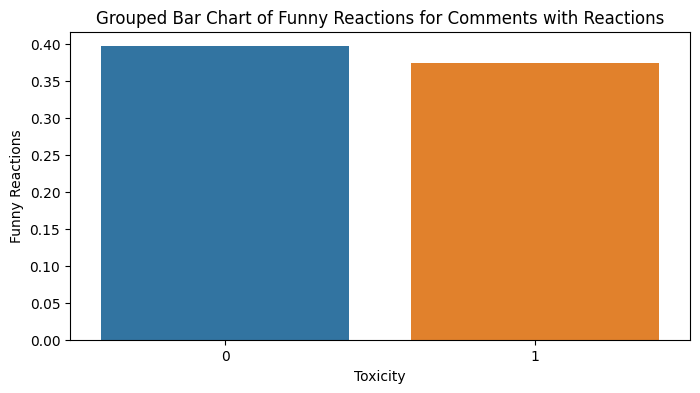

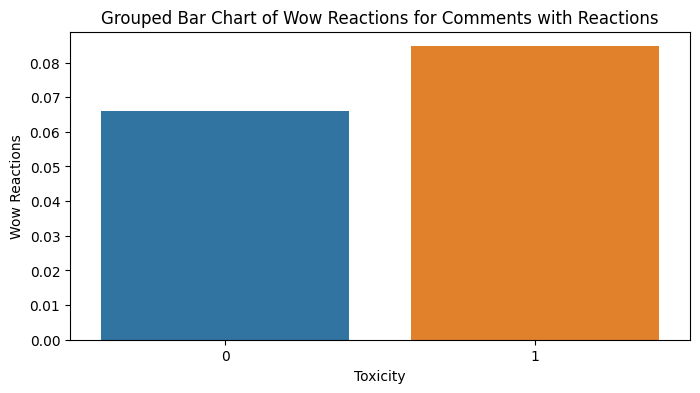

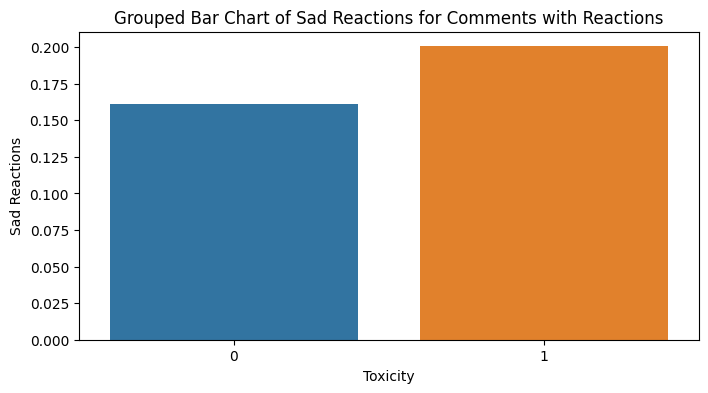

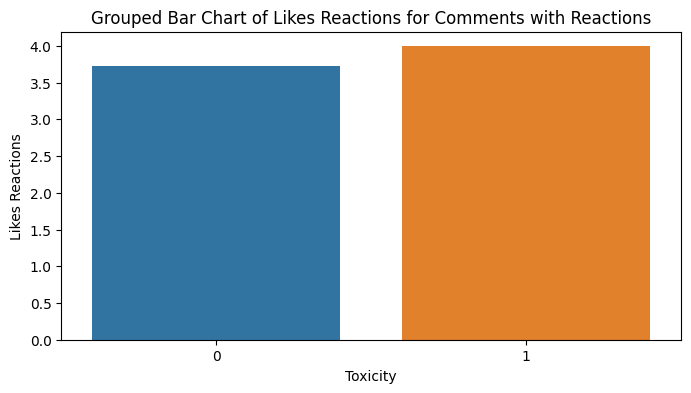

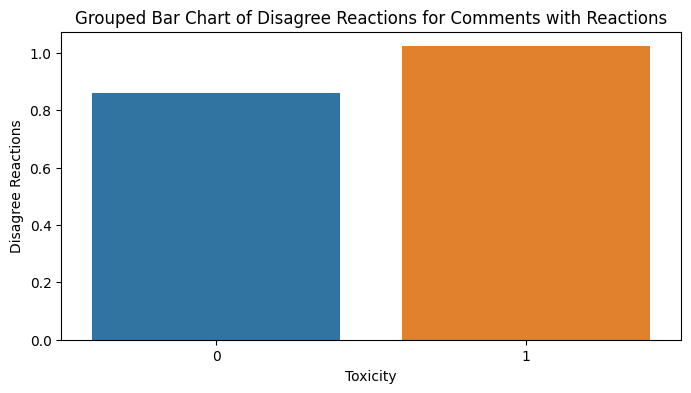

In [51]:
df_react_with_reaction = \
    df_react[df_react[['funny', 'wow', 'sad','likes', 'disagree']].sum(axis=1) > 0]

reactions = ['funny', 'wow', 'sad', 'likes', 'disagree']

for reaction in reactions:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_react_with_reaction, x='toxic',
                y=reaction, errorbar=None)
    plt.title(f'Grouped Bar Chart of {reaction.capitalize()} Reactions for Comments with Reactions')
    plt.xlabel('Toxicity')
    plt.ylabel(f'{reaction.capitalize()} Reactions')